# Algorithm Comparison

In [ ]:
from mcmc_sampling.utils import l2_sym
import numpy as np
import arviz
import matplotlib.pyplot as plt
from utils import plotting
import mhn
from mhn.mcmc.mcmc import MCMC
from mhn.mcmc.kernels import RWMKernel, MALAKernel, smMALAKernel
import time

import sys
sys.path.append("..")

burn_in = 0.2

In [2]:
data = np.loadtxt(f"../data/G13_LUAD_12.csv", delimiter=",", skiprows=1,
                  usecols=range(1, 13), dtype=np.int32)
mhn_model = mhn.model.oMHN.load(
    f"../results/mhns/G13_LUAD_12_sym-l2_mle.csv")

for algo_name, kernel in [("RWM", RWMKernel),
                          ("MALA", MALAKernel),
                          ("smMALA", smMALAKernel)]:
    mcmc_sampler = MCMC(
        mhn_model=mhn_model,
        data=data,
        penalty=(l2_sym.gaussian_sym_log_prior,
                l2_sym.gaussian_sym_log_prior_grad,
                l2_sym.gaussian_sym_log_prior_hessian),
        kernel_class=kernel,
        step_size=0.001,
        thin=1,
    )
    t0 = time.time()
    mcmc_sampler.run(max_steps=100)
    t1 = time.time()
    print(f"{algo_name}:\t {(t1 - t0)/100:.5f} seconds per step")

RWM:	 0.06712 seconds per step
MALA:	 0.06758 seconds per step
smMALA:	 1.16653 seconds per step


In [ ]:
samples_rwm = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_RWM_0_128125.npy")
samples_mala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_MALA_0_0015625.npy")
samples_smmala = np.load(
    "../results/mcmc/G13_LUAD_12_sym-l2_smMALA_0_029335937500000003.npy")

In [56]:
_min = min(sample.shape[1] for sample in
           [samples_rwm, samples_mala, samples_smmala])

rhats = {
    algo_name: np.array([arviz.rhat(
        arviz.convert_to_dataset(samples[:, int(n * burn_in):n])).x
        for n in range(13, _min, 4)])
    for algo_name, samples in zip(
        ["RWM", "MALA", "smMALA"],
        [samples_rwm, samples_mala, samples_smmala])
}

/home/lhu/mhn_env/lib/python3.10/site-packages/arviz/data/base.py:272: UserWarning: More chains (10) than draws (8). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


(0.95, 1.5)

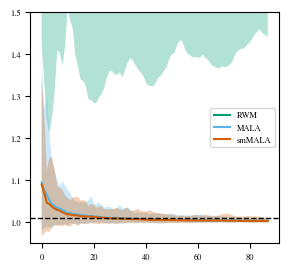

In [58]:
fig, ax = plt.subplots(figsize=(3.21, 3))

for algo_name, rhat_values in rhats.items():
    ax.plot(range(len(rhat_values)), rhat_values.mean(axis=1), label=algo_name)
    ax.fill_between(range(len(rhat_values)), rhat_values.min(axis=1), rhat_values.max(axis=1), alpha=0.3)
ax.axhline(1.01, color='black', linestyle='--', lw=1)
ax.legend()
ax.set_ylim(0.95, 1.5)

In [67]:
print("Minimal max(R hat) values for RWM:", end=' ')
print(float(arviz.rhat(arviz.convert_to_dataset(samples_rwm[:, int(samples_rwm.shape[1] * burn_in):])).x.min()))

Minimal max(R hat) values for RWM: 1.2689985661537238
